In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, ImageCollection
import cv2
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import fastai
from fastai.vision.all import *
import albumentations as alb
from albumentations import ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
from PIL import Image
import seaborn as sns
import collections
from ipywidgets import FileUpload
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import datetime


## Loading and Exploration

In [2]:
# Create the ImageCollection object
skimage_collection = ImageCollection('/Users/maxwellkreitman/Desktop/CV_flower_project/pics/*.jpg', load_func=imread, conserve_memory=False, plugin='matplotlib')

# Print the number of images loaded
print(f"Number of images loaded: {len(skimage_collection)}")

Number of images loaded: 8189


In [3]:
#loading imagelabels.mat MATLAB file
mat_labels = loadmat('imagelabels.mat')

In [4]:
print(mat_labels.keys())

dict_keys(['__header__', '__version__', '__globals__', 'labels'])


In [5]:
labels = mat_labels['labels'].tolist()
label_list = []
label_list.extend(labels[0])


In [6]:
#creating dataframe from mat_labels
df = pd.DataFrame({"flower_id" : list(range(1,8190)), "label_id" : mat_labels['labels'][0]})

In [7]:
#compiled list of English labels from 
NAMES = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "english marigold",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia?",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen",
    "watercress",
    "canna lily",
    "hippeastrum",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
]

In [8]:
df["class"] = df['label_id'].map(lambda x: NAMES[x-1])

In [9]:
df.head()

,flower_id,label_id,class
0,1,77,passion flower
1,2,77,passion flower
2,3,77,passion flower
3,4,77,passion flower
4,5,77,passion flower


In [10]:
#confirming an equal number of labels to picture files of 8,189
print(f"Number of labels loaded: {len(label_list)}")

Number of labels loaded: 8189


In [11]:
#confirming the list has 102 classes as described in the readme
print(f"Number of classes in data: {len(set(label_list))}")

Number of classes in data: 102


In [12]:
#counting occurance of every class between 1 and 102
pic_counts = Counter(label_list)

In [13]:
print(pic_counts)

Counter({51: 258, 77: 251, 46: 196, 73: 194, 89: 184, 74: 171, 81: 166, 94: 162, 88: 154, 78: 137, 83: 131, 43: 130, 95: 128, 41: 127, 75: 120, 58: 114, 82: 112, 56: 109, 60: 109, 37: 108, 76: 107, 80: 105, 65: 102, 72: 96, 44: 93, 53: 93, 50: 92, 23: 91, 96: 91, 11: 87, 12: 87, 84: 86, 8: 85, 30: 85, 17: 85, 52: 85, 18: 82, 90: 82, 98: 82, 29: 78, 71: 78, 91: 76, 36: 75, 48: 71, 55: 71, 40: 67, 47: 67, 59: 67, 57: 67, 92: 66, 28: 66, 97: 66, 5: 65, 85: 63, 87: 63, 99: 63, 70: 62, 54: 61, 66: 61, 2: 60, 22: 59, 42: 59, 86: 58, 101: 58, 20: 56, 4: 56, 38: 56, 62: 55, 63: 54, 68: 54, 69: 54, 64: 52, 31: 52, 61: 50, 13: 49, 19: 49, 49: 49, 15: 49, 100: 49, 14: 48, 102: 48, 93: 46, 9: 46, 33: 46, 32: 45, 10: 45, 6: 45, 35: 43, 24: 42, 67: 42, 26: 41, 25: 41, 16: 41, 79: 41, 39: 41, 3: 40, 1: 40, 21: 40, 27: 40, 34: 40, 45: 40, 7: 40})


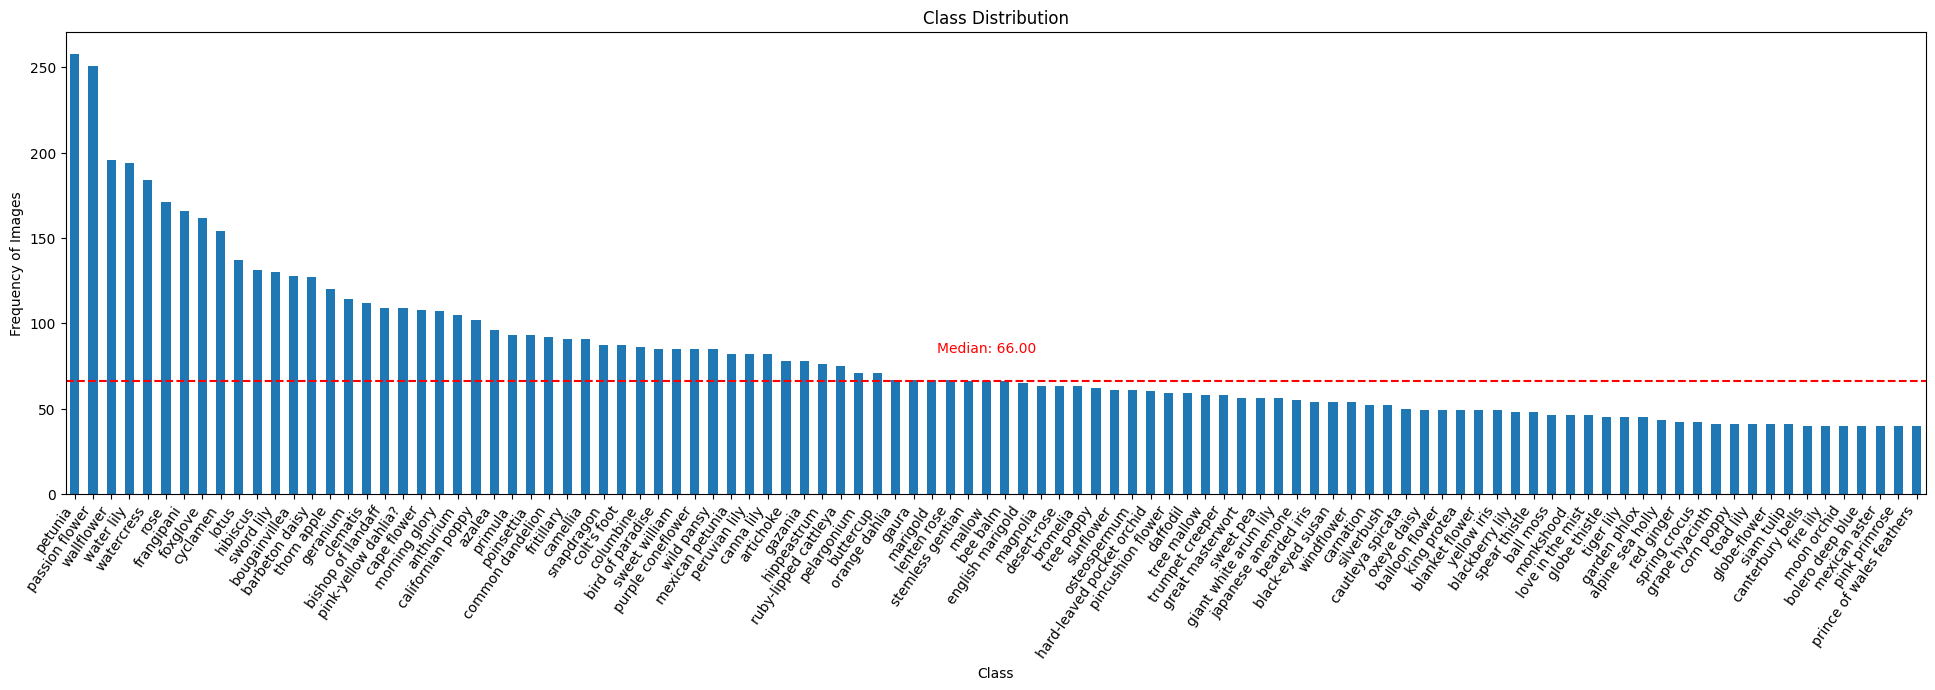

In [14]:
median_value = np.median(df['class'].value_counts())
#visualizing the distribution over all classes
class_counts = df['class'].value_counts()
plt.figure(figsize=(24, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency of Images')
plt.title('Class Distribution')
plt.axhline(y=median_value, color='red', linestyle='--', label='Average Frequency')
plt.text(50, median_value + 15, f'Median: {median_value:.2f}', color='red', ha='center', va='bottom')
plt.xticks(rotation=55, ha='right')
plt.show()

##### Class imbalance seems to be an issue here.  I plan to use weighted loss during dataloader step.

In [15]:
# Calculating class weights
total_samples = sum(pic_counts.values())
class_weights = [total_samples / (len(pic_counts) * pic_counts[class_i]) for class_i in pic_counts.keys()]

total_weight = sum(class_weights)
#normalizing class weights
class_weights_normalized = [weight / total_weight for weight in class_weights]

In [16]:
#minimum frequency of images over all class labels
print(f"Minimum value in the dictionary of labels: {min(pic_counts.values())}")
print(f"Maximum value in the dictionary of labels: {max(pic_counts.values())}")

Minimum value in the dictionary of labels: 40
Maximum value in the dictionary of labels: 258


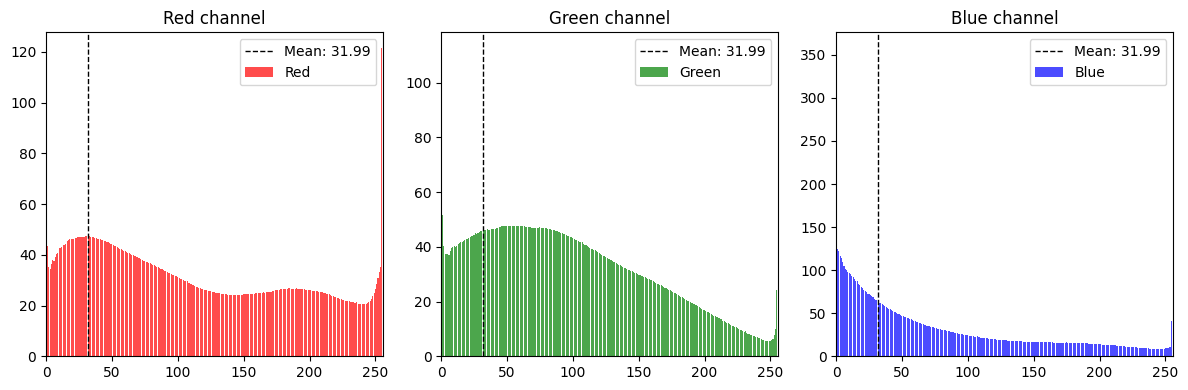

In [17]:
# Initializing arrays to hold all pixel histograms of each channel
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

# Iterate through each image in the collection
for img in skimage_collection:

    # Split the image into its respective channels
    r, g, b = cv2.split(img)
    
    # Compute histogram for each channel and accumulate
    hist_r += np.histogram(r, bins=256, range=[0,256], density=True)[0]
    hist_g += np.histogram(g, bins=256, range=[0,256], density=True)[0]
    hist_b += np.histogram(b, bins=256, range=[0,256], density=True)[0]

#Median & mean calculations
mean_r = np.mean(hist_r)
mean_g = np.mean(hist_g)
mean_b = np.mean(hist_b)
    
# Prepare bins for histogram
bins = np.arange(256)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram for Red channel
axs[0].bar(bins, hist_r, color='red', alpha=0.7, label='Red')
axs[0].set_title('Red channel')
axs[0].set_xlim([0,256])
axs[0].axvline(mean_r, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_r:.2f}')
axs[0].legend()

# Plot histogram for Green channel
axs[1].bar(bins, hist_g, color='green', alpha=0.7, label='Green')
axs[1].set_title('Green channel')
axs[1].set_xlim([0,256])
axs[1].axvline(mean_g, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_g:.2f}')
axs[1].legend()

# Plot histogram for Blue channel
axs[2].bar(bins, hist_b, color='blue', alpha=0.7, label='Blue')
axs[2].set_title('Blue channel')
axs[2].set_xlim([0,256])
axs[2].axvline(mean_b, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_b:.2f}')
axs[2].legend()

# Add legend
for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()

### Both red and green channel have right-skew shape.

### Spot checking 4 images belonging to the first 4 classes

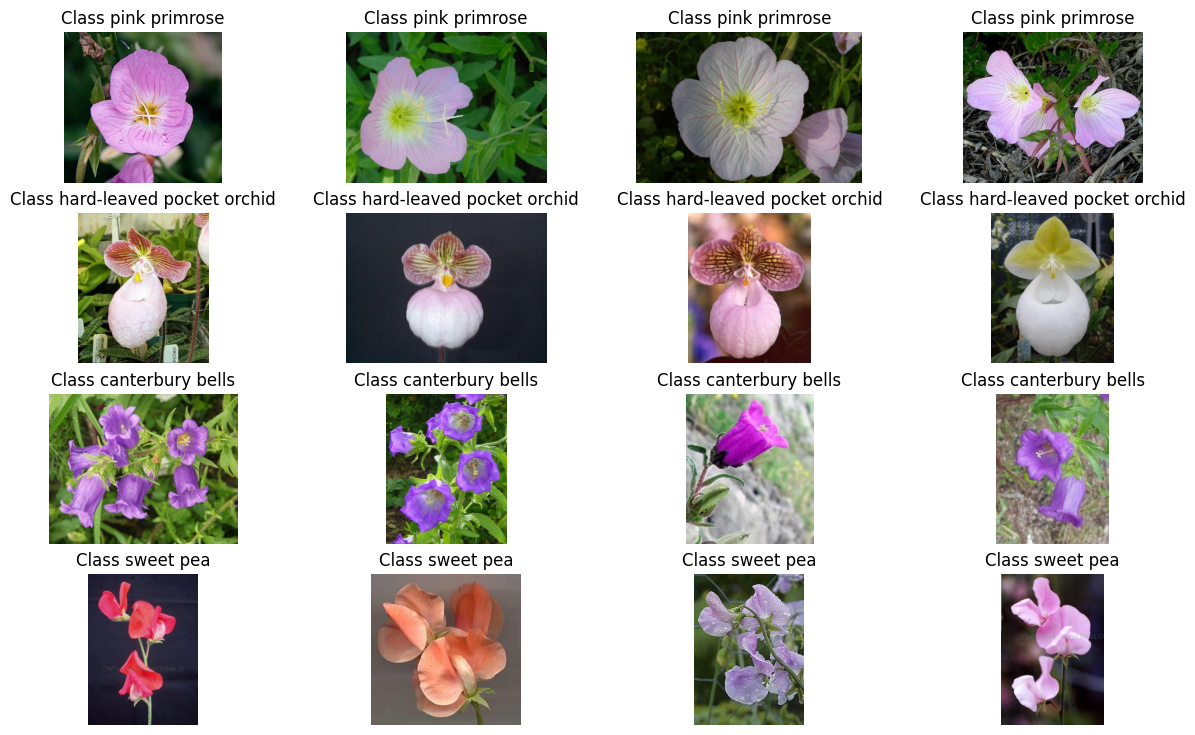

In [18]:
#determining image index group belonging to each class
label_1_indices = np.where(np.array(label_list) == 1)[0][:4]
label_2_indices = np.where(np.array(label_list) == 2)[0][:4]
label_3_indices = np.where(np.array(label_list) == 3)[0][:4]
label_4_indices = np.where(np.array(label_list) == 4)[0][:4]

#plotting images
fig, axes = plt.subplots(4, 4, figsize=(15, 9))

for i, indices in enumerate([label_1_indices, label_2_indices, label_3_indices, label_4_indices]):
    for j, index in enumerate(indices):
        image = skimage_collection[index]
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'Class {df.iloc[index]["class"]}')
        axes[i, j].axis('off')

plt.show()

### Shape and pattern of the flower can vary between pictures of the same class.  There are many instances of complex backgrounds and color variations as well.

### Now I want to visualize the distribution of image dimensions in my data.

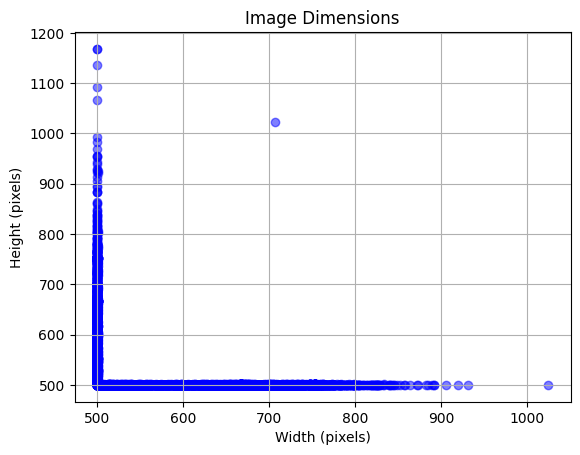

In [19]:
#creating a list of tuples that hold the shape (width and height) of each image
image_dimensions = [(image.shape[1], image.shape[0]) for image in skimage_collection]
#unzipping image_dimensions 
widths, heights = zip(*image_dimensions)
#building a scatter plot
plt.scatter(widths, heights, marker='o', color='blue', alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

### While there are a few outliers, the rest seem to be reasonably similar in size.

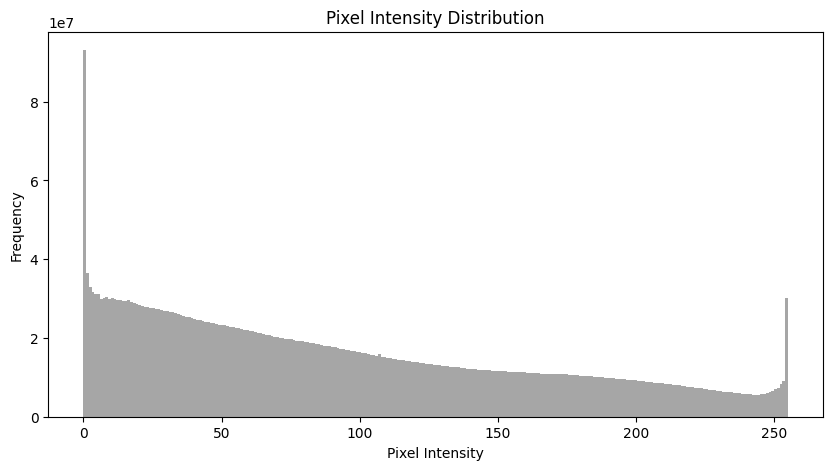

In [20]:
#exploring pixel intensity on the first half the images

# Specify the path to the directory containing your images
images_directory = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/"
all_image_paths = glob.glob(images_directory + "*.jpg")  

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[:split_index]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

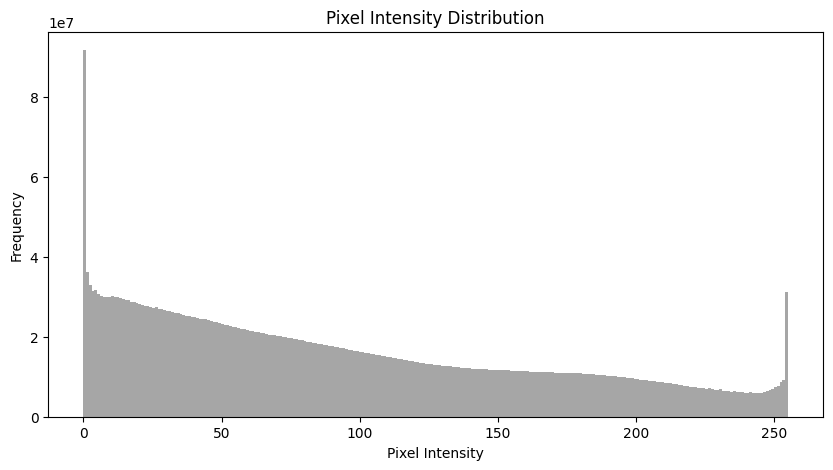

In [21]:
#exploring pixel intensity on second half the images

# Specify the path to the directory containing your images
images_directory = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/"
all_image_paths = glob.glob(images_directory + "*.jpg")  

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[split_index:]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

### Both graphs show a negative linear relationship and no aparent peak. There are outlier spikes at left and righthand sides.

In [22]:
#loading image files into folder called images
images = get_image_files("/Users/maxwellkreitman/Desktop/CV_flower_project/pics")


In [23]:
def first_three(image_list):
    resized_images = []
    for path in image_list[:3]:
        img = Image.open(path)
        resized_img = img.resize((img.width // 4, img.height // 4))
        resized_images.append(resized_img)
    return display(resized_images[0]), display(resized_images[1]), display(resized_images[2])

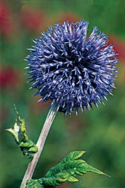

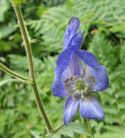

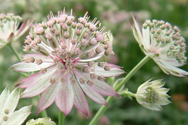

(None, None, None)

In [24]:
first_three(images)


Problem!  This flower is not the passion flower from img_00001.jpg.  The get_images_files sorting method is messing up the order of flowers.

In [25]:
# Sorting images based on filename sequence in dataset
def custom_sort(file_path):
    # Extract numeric part from the file name (assuming it ends with a number)
    return int(''.join(filter(str.isdigit, file_path.stem)))

# Sort the images based on the custom sorting function
images = sorted(images, key=custom_sort)

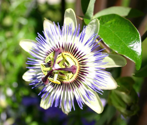

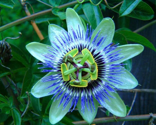

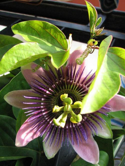

(None, None, None)

In [26]:
first_three(images)

#### Fixed!  The first three pictures are a passion flowers (image_00001.jpg, image_00002.jpg, image_00003.jpg).

In [27]:
class_list = df['class'].tolist()

train_images, test_images = train_test_split(images, test_size=0.1, random_state=25)
train_label_list, test_label_list = train_test_split(class_list, test_size=0.1, random_state=25)


## Modeling

#### Building baseline model with normalization and class_weights to help with imbalanced classes. 

In [28]:
#Create ImageDataLoader
dl_base = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(128),
       batch_tfms=[Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [29]:
#create model
learn_base = vision_learner(dl_base, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0010000000474974513)

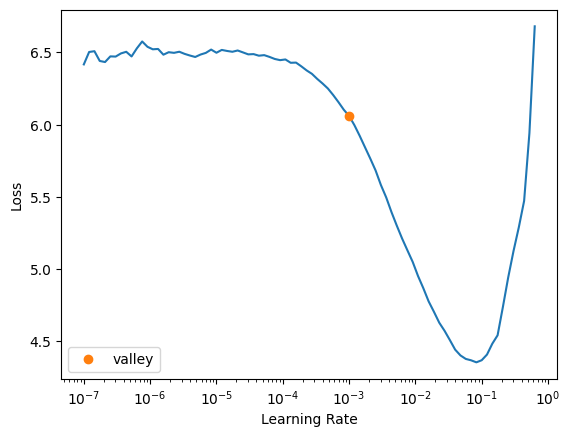

In [30]:
learn_base.lr_find()

In [31]:
learn_base.fit_one_cycle(6, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.321975,0.693815,0.177748,02:27
1,0.948448,0.501231,0.140434,02:34
2,0.475384,0.381359,0.108548,02:34
3,0.272864,0.291024,0.090231,02:38
4,0.146088,0.241427,0.067164,02:50
5,0.083806,0.234151,0.067164,03:01


epoch,train_loss,valid_loss,error_rate,time
0,0.186518,0.394766,0.105834,02:46


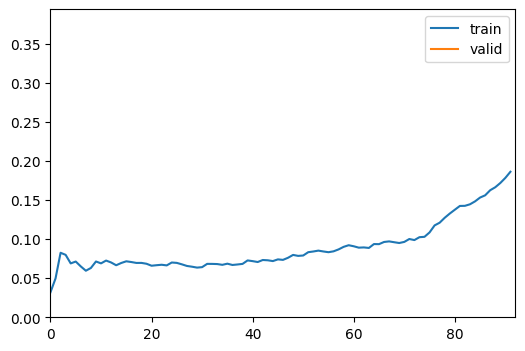

epoch,train_loss,valid_loss,error_rate,time
0,0.141176,0.323613,0.081411,04:07
1,0.281444,0.442730,0.113976,04:01
2,0.202839,0.314105,0.083446,04:11
3,0.102002,0.250546,0.072592,03:53
4,0.044942,0.198858,0.054953,03:56
5,0.023264,0.194628,0.055631,04:00


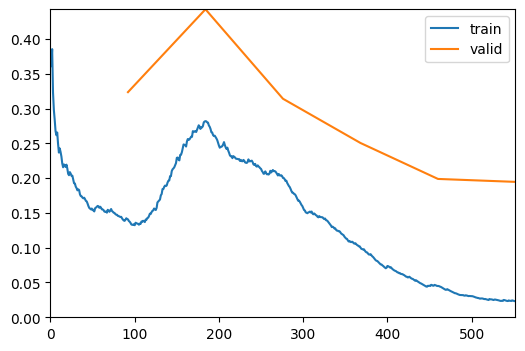

In [32]:
#tuning hyperparameters
learn_base.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [33]:
results = learn_base.validate()
accuracy_percentage_cv = (1 - results[1]) * 100
print(f"cv_learn model's overall accuracy: {accuracy_percentage_cv:.1f}%")

cv_learn model's overall accuracy: 94.4%


In [34]:
validation_percentage_cv = results[0] * 100
print(f"Validation Loss: {validation_percentage_cv:.1f}%")

Validation Loss: 19.5%


In [35]:
# for the remaining models to compare with this one
def results(model):
    validation, accuracy = model.validate()
    accuracy_percentage = (1 - accuracy) * 100
    validation_percentage = validation * 100
    print(f"Model's overall accuracy: {accuracy_percentage:.1f}%")
    difference = accuracy_percentage - accuracy_percentage_cv 
    print(f"The accuracy change over the baseline model is {difference:.1f}%")
    print(f"Model's validation loss: {validation_percentage:.1f}%")
    difference =  validation_percentage - validation_percentage_cv
    print(f"The validation change over the baseline model is {difference:.1f}%")


#### New model with augmentation transformations from aug_transforms() default parameters.

In [36]:
#transformations list
transforms_1 = aug_transforms( 
        mult = 1.0, 
        do_flip = True, 
        flip_vert = False, 
        max_rotate = 10.0, 
        min_zoom = 1.0, 
        max_zoom = 1.1, 
        max_lighting = 0.2, 
        max_warp = 0.2, 
        p_affine = 0.75, 
        p_lighting = 0.75, 
        xtra_tfms = None, 
        size = None, 
        mode= 'bilinear', 
        pad_mode='reflection', 
        align_corners=True, 
        batch=False, 
        min_scale=1.0)

In [37]:
#Create ImageDataLoader
dl_1 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(128),
       batch_tfms=[*transforms_1, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [38]:
#create model
learn_1 = vision_learner(dl_1, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0005754399462603033)

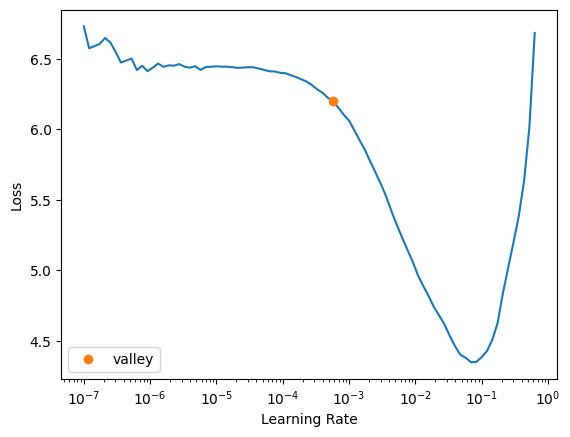

In [39]:
learn_1.lr_find()

In [40]:
learn_1.fit_one_cycle(6, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.401299,0.742537,0.199457,02:55
1,1.060896,0.494928,0.137042,02:50
2,0.580214,0.408628,0.113976,02:48
3,0.347170,0.317434,0.080733,02:52
4,0.208120,0.255309,0.062415,02:51
5,0.141870,0.247819,0.063094,02:58


epoch,train_loss,valid_loss,error_rate,time
0,0.237132,0.373625,0.097693,02:59


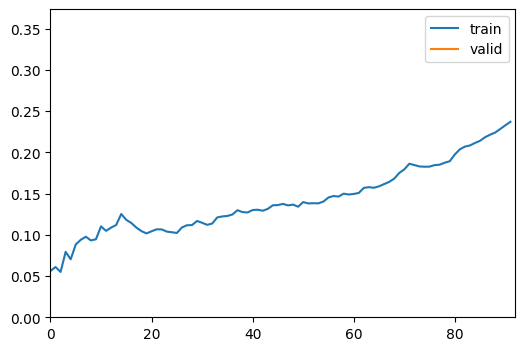

epoch,train_loss,valid_loss,error_rate,time
0,0.222847,0.369025,0.091588,04:04
1,0.302689,0.462913,0.121438,03:45
2,0.252260,0.387468,0.103799,03:45
3,0.143338,0.263498,0.063094,03:55
4,0.066306,0.216949,0.052239,03:58
5,0.045062,0.194243,0.050204,03:53


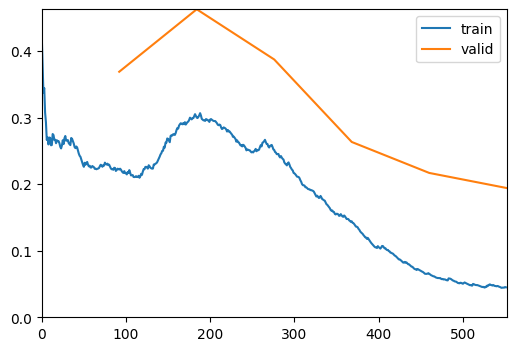

In [41]:
#tuning hyperparameters
learn_1.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [42]:
results(learn_1)

Model's overall accuracy: 95.0%
The accuracy change over the baseline model is 0.5%
Model's validation loss: 19.4%
The validation change over the baseline model is -0.0%


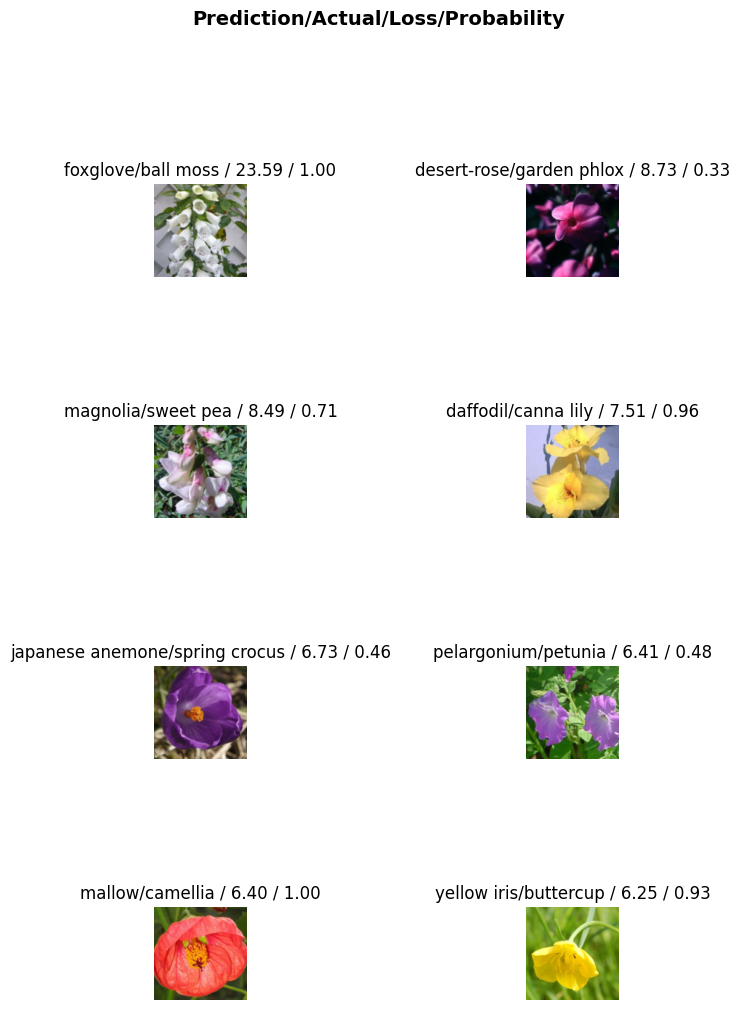

In [43]:
#observing some erroneous predictions
interp = ClassificationInterpretation.from_learner(learn_1)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()

#### Trying another model with two different augmentation parameters that include mode set to 'nearest' and pad_mode set to 'zeros'.

In [44]:
#transformations list
transforms_2 = aug_transforms( 
        mult = 1.0, 
        do_flip = True, 
        flip_vert = False, 
        max_rotate = 10.0, 
        min_zoom = 1.0, 
        max_zoom = 1.1, 
        max_lighting = 0.2, 
        max_warp = 0.2, 
        p_affine = 0.75, 
        p_lighting = 0.75, 
        xtra_tfms = None, 
        size = None, 
        mode= 'nearest', #changed from 'bilinear'
        pad_mode='zeros', #changed from 'reflection'
        align_corners=True, 
        batch=False, 
        min_scale=1.0)

In [45]:
#Create ImageDataLoader
dl_2 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(128),
       batch_tfms=[*transforms_2, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [46]:
#create model
learn_2 = vision_learner(dl_2, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

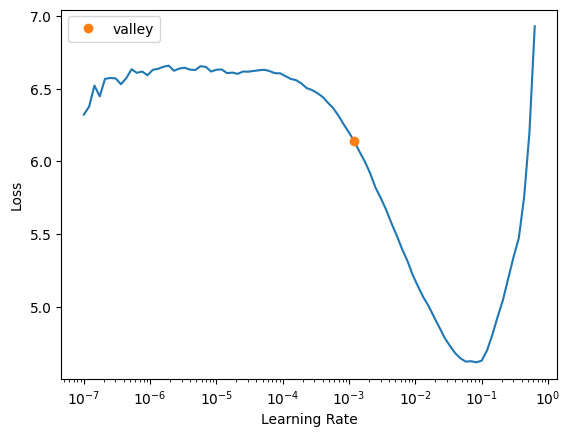

In [47]:
learn_2.lr_find()

In [48]:
learn_2.fit_one_cycle(6, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.478060,0.890108,0.240163,02:57
1,1.169718,0.544318,0.158752,02:56
2,0.641231,0.351363,0.097015,02:49
3,0.399550,0.285566,0.077341,02:50
4,0.262017,0.244423,0.062415,02:45
5,0.197739,0.235772,0.061737,02:53


epoch,train_loss,valid_loss,error_rate,time
0,0.272618,0.386649,0.109905,02:56


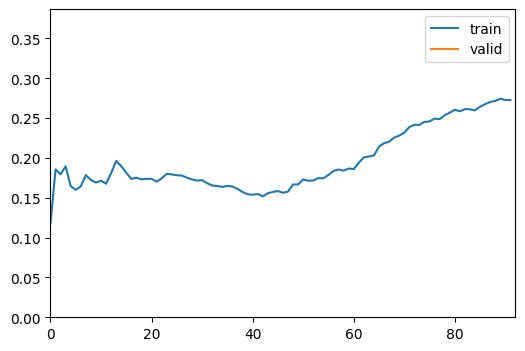

epoch,train_loss,valid_loss,error_rate,time
0,0.312339,0.352199,0.091588,03:50
1,0.373482,0.430625,0.106513,03:51
2,0.286937,0.285018,0.088195,03:53
3,0.161284,0.169512,0.050204,03:59
4,0.079461,0.152207,0.041384,04:00
5,0.048863,0.142682,0.037992,03:55


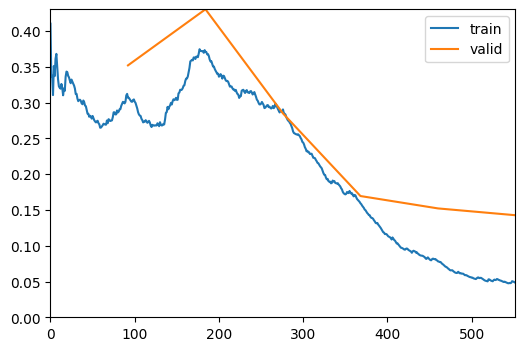

In [49]:
#tuning hyperparameters
learn_2.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [50]:
results(learn_2)

Model's overall accuracy: 96.2%
The accuracy change over the baseline model is 1.8%
Model's validation loss: 14.3%
The validation change over the baseline model is -5.2%


#### Improved accuracy and validation loss.  I will continue using 'nearest' and 'zeros' mode and padding parameters with the following model trials.  
#### Now I want to explore a new model with larger images (224 pixels).

In [51]:
#transformations list
transforms_3 = aug_transforms( 
        mult = 1.0, 
        do_flip = True, 
        flip_vert = False, 
        max_rotate = 10.0, 
        min_zoom = 1.0, 
        max_zoom = 1.1, 
        max_lighting = 0.2, 
        max_warp = 0.2, 
        p_affine = 0.75, 
        p_lighting = 0.75, 
        xtra_tfms = None, 
        size = None, 
        mode= 'nearest', #changed from 'bilinear'
        pad_mode='zeros', #changed from 'reflection'
        align_corners=True, 
        batch=False, 
        min_scale=1.0)

In [52]:
#Create ImageDataLoader
dl_3 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(224),
       batch_tfms=[*transforms_3, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [53]:
#create model
learn_3 = vision_learner(dl_3, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0006918309954926372)

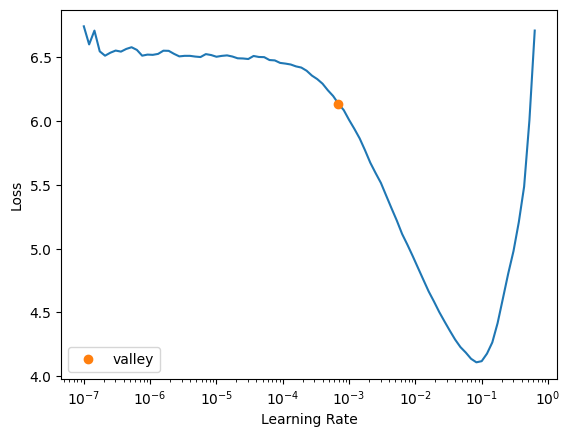

In [54]:
learn_3.lr_find()

In [55]:
learn_3.fit_one_cycle(6, lr_max = 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.611080,0.438393,0.124830,09:59
1,0.747227,0.522582,0.146540,10:10
2,0.446830,0.299949,0.080733,10:34
3,0.268065,0.197652,0.051560,10:47
4,0.134253,0.117544,0.029172,10:58
5,0.079892,0.106200,0.026459,10:49


epoch,train_loss,valid_loss,error_rate,time
0,0.217244,0.287916,0.082768,10:40


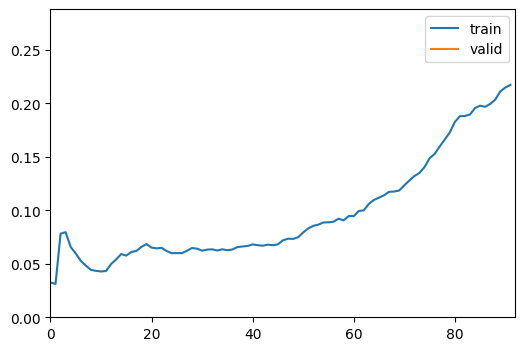

epoch,train_loss,valid_loss,error_rate,time
0,0.247912,0.346942,0.086839,13:20
1,0.387771,0.407800,0.103121,35:48
2,0.282057,0.295601,0.068521,12:28
3,0.171658,0.139229,0.037313,12:18
4,0.070601,0.081344,0.021031,12:32
5,0.031838,0.076287,0.021031,12:23


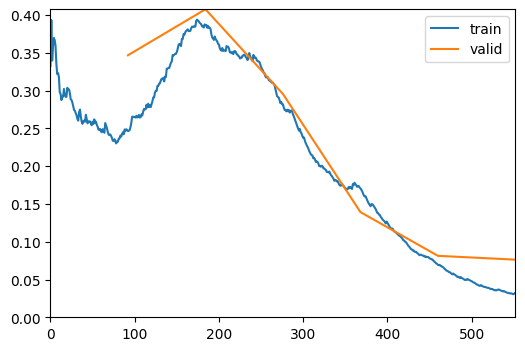

In [56]:
#tuning hyperparameters
learn_3.fine_tune(6, 5e-3, cbs=ShowGraphCallback())

In [57]:
results(learn_3)

Model's overall accuracy: 97.9%
The accuracy change over the baseline model is 3.5%
Model's validation loss: 7.6%
The validation change over the baseline model is -11.8%


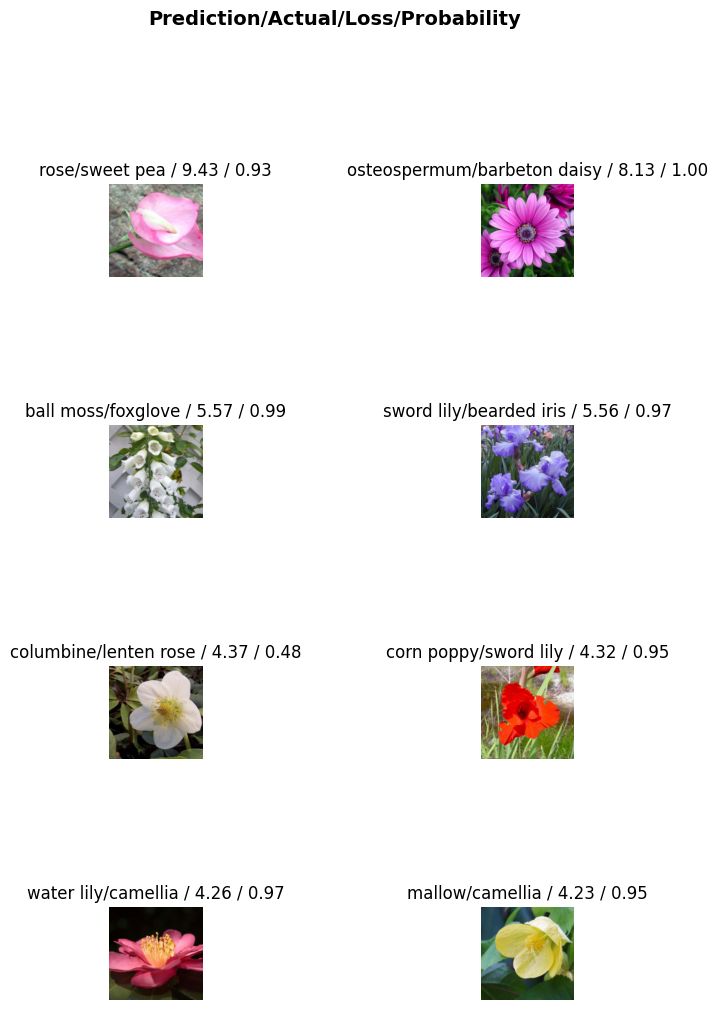

In [58]:
interp = ClassificationInterpretation.from_learner(learn_3)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()

#### Testing the best model for real-world prediction accuracy.

In [59]:
#Creating ImageDataLoader from learn_3's dataloader object on test_items and test_label_list
dls = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=test_images,
       labels=test_label_list,
       valid_pct=0.2,
       item_tfms=Resize(224),
       batch_tfms=[*transforms_3, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [60]:
# Recreate the test dataloader
test_dl = dls.test_dl(test_images)

# Calculating predictions and validation data.
preds, _ = learn_3.get_preds(dl=test_dl)

In [61]:
# I need to convert my list of labels to a tensor, 
# but there is an intermediate string label -> numerical label step
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(test_label_list)
test_labels_tensor = tensor(encoded_labels)

In [73]:
acc = accuracy(preds, test_labels_tensor)
accuracy_percentage_test = acc.item()

In [74]:
print(f"Test set accuracy: {accuracy_percentage_test:.2%}")


Test set accuracy: 98.78%


In [79]:
def save_results_to_file(model):
    validation, accuracy = model.validate()
    accuracy_percentage = (1 - accuracy) * 100
    validation_percentage = validation * 100

    difference_accuracy = accuracy_percentage - accuracy_percentage_cv
    difference_validation = validation_percentage - validation_percentage_cv

    # Create a string with the results
    output_content = f"Model's overall accuracy: {accuracy_percentage:.1f}%\n" \
                     f"The accuracy change over the baseline model is {difference_accuracy:.1f}%\n" \
                     f"Model's validation loss: {validation_percentage:.1f}%\n" \
                     f"The validation change over the baseline model is {difference_validation:.1f}%\n"\
                     f"Test set accuracy: {accuracy_percentage_test:.2%}"
    
    # Get today's date
    today_date = datetime.date.today().strftime("%d_%m_%y")
    
    directory_path = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/models"

    # Create the file name
    file_name = os.path.join(directory_path, f"best_model_results_{today_date}.txt")

    # Write content to the file
    with open(file_name, 'w') as file:
        file.write(output_content)

    print(f"Results saved in file '{file_name}'.")

In [80]:
save_results_to_file(learn_3)

Results saved in file '/Users/maxwellkreitman/Desktop/CV_flower_project/pics/models/best_model_results_27_01_24.txt'.
